In [10]:
import sys
import os
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(1, '../../../notes/1-Testing/fuzzy-test/python/')

In [11]:
from fuzzy_system import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
FOLDERS = ["approach1", "approach2"]

In [13]:
def parseVariables(VariableString):
    inputVariables = []

    for axis in VariableString.split("\n\n"):
        if not axis:
            continue

        # Axis: maxParticlesPerCell range: (0.00, 35.00)
        nameStr = re.search(r"FuzzyVariable: domain: \"(.*)\"", axis).group(1)
        rangeStr = re.search(r"range: \((.*), (.*)\)", axis)

        variable = LinguisticVariable(
            CrispSet({(nameStr, make_continuousSet((float(rangeStr.group(1)), float(rangeStr.group(2)))))}))

        for rule in axis.strip().split("\n")[1:]:
            name = re.search(r"^\s*\"(.*)\":", rule).group(1)
            func = re.search(r": (\w+)\(", rule).group(1)
            params = re.search(r"\((.+)\)", rule).group(1).split(", ")
            if func == "Gaussian":
                variable.add_linguistic_term(Gaussian(name,
                                                      float(params[0]), float(params[1])))
            elif func == "Sigmoid":
                variable.add_linguistic_term(Sigmoid(
                    name, float(params[0]), float(params[1])))
            elif func == "SigmoidFinite":
                variable.add_linguistic_term(SigmoidFinite(
                    name, float(params[0]), float(params[1]), float(params[2])))
            else:
                raise Exception("Unknown function: "+func)

        inputVariables.append(variable)

    return inputVariables

In [14]:
def constructFuzzySet(variables, terms: list[list[tuple[str, str]]]):
    fuzzySet = None
    for and_list in terms:
        or_set = None
        for (term, comp, value) in and_list:
            a = None
            for i in variables:
                for (name, _) in i.crisp_set.dimensions:
                    if name == term:
                        a = i
                        break

            if a is None:
                raise ValueError(f"Variable {term} not found")

            curr_set = (a == value) if comp == "==" else ~(a == value)

            or_set = curr_set | or_set if or_set is not None else curr_set

        fuzzySet = fuzzySet & or_set if fuzzySet is not None else or_set
    return fuzzySet


def parseRules(rulesString: str):
    andLists = []
    for antecedent in rulesString.split("&&"):
        andString = re.search(r"\((.+)\)", antecedent).group(1)
        orStrings = andString.split("||")

        negateAnd = False
        if (andString[0] == '!'):
            negateAnd = True

        or_list = []
        for orString in orStrings:
            term = re.search(r"\(?\"(.*)\" == \"(.*)\"\)?", orString)

            op = "!=" if negateAnd else "=="

            or_list.append((term.group(1), op, term.group(2)))

        andLists.append(or_list)

    return andLists

In [15]:
def createFuzzySystem(inputVariableString, outputVariableString, rulesString):
    inputVariables = parseVariables(inputVariableString)
    outputVariables = parseVariables(outputVariableString)

    variables = inputVariables + outputVariables

    rules = []
    for rule in rulesString.strip().split("\n"):
        antecedentsString = re.search(r"if (.+) then", rule).group(1)
        consequentList = re.search(r"then (.+)", rule).group(1)

        antecedent = constructFuzzySet(
            variables, parseRules(antecedentsString))

        consequent = constructFuzzySet(variables, parseRules(consequentList))

        rules.append(FuzzyRule(antecedent, consequent))

    algo_rankings = {}

    for output in outputVariables:
        name = next(iter(output.crisp_set.dimensions))[0]

        for linguistic_term, membershipFunc in output.linguistic_terms.items():
            peak = membershipFunc.peak()
            if name not in algo_rankings:
                algo_rankings[name] = {}
            algo_rankings[name][linguistic_term] = peak

    print("Number of rules: ", len(rules))
    print("Number of input variables: ", len(inputVariables))
    print("Number of output variables: ", len(outputVariables))

    fuzzy_systems = {}

    for rule in rules:
        dims = rule.consequent.crisp_set.dimensions
        assert len(dims) == 1
        output_variable = next(iter(dims))[0]

        if output_variable not in fuzzy_systems:
            fuzzy_systems[output_variable] = FuzzySystem()
        fuzzy_systems[output_variable].add_rule(rule)

    return fuzzy_systems, algo_rankings

In [16]:
train_total = pd.read_pickle("train.pkl")
test_total = pd.read_pickle("test.pkl")

TOP_K_SAMPLES = 1

train = train_total[train_total["ranking"] < TOP_K_SAMPLES]
test = test_total[test_total["ranking"] < TOP_K_SAMPLES]

In [17]:
from collections import defaultdict


def calc_accuracy(fisys: FuzzySystem, algo_rankings: dict[str, dict[str, float]]):
    freq_correct_test = defaultdict(int)
    freq_total_test = defaultdict(int)

    freq_correct_train = defaultdict(int)
    freq_total_train = defaultdict(int)

    output_variable = fisys.consequent_name

    for row in test.iterrows():
        val, pred = fisys.predictClosest(
            row[1], algo_rankings[output_variable])

        true = row[1][output_variable]
        if pred == true:
            freq_correct_test[true] = freq_correct_test.get(true, 0) + 1
        freq_total_test[true] = freq_total_test.get(true, 0) + 1

    for row in train.iterrows():
        val, pred = fisys.predictClosest(
            row[1], algo_rankings[output_variable])

        true = row[1][output_variable]
        if pred == true:
            freq_correct_train[true] = freq_correct_train.get(true, 0) + 1
        freq_total_train[true] = freq_total_train.get(true, 0) + 1

    return freq_correct_test, freq_total_test, freq_correct_train, freq_total_train

In [18]:
def plot_accuracy(folder, fuzzy_systems, algo_rankings):
    accuracies = {}

    for label, fisys in fuzzy_systems.items():

        print(f"\n{label}:")

        freq_correct_test, freq_total_test, freq_correct_train, freq_total_train = calc_accuracy(
            fisys, algo_rankings)

        freq_total_test["Total"] = sum(freq_total_test.values())
        freq_correct_test["Total"] = sum(freq_correct_test.values())

        freq_total_train["Total"] = sum(freq_total_train.values())
        freq_correct_train["Total"] = sum(freq_correct_train.values())

        accuracies[label] = (freq_correct_test["Total"] / freq_total_test["Total"],
                             freq_correct_train["Total"] / freq_total_train["Total"])

        print("\tTest set:")
        for key in freq_total_test.keys():
            print(f"\t\t{key:24}: {100*freq_correct_test[key] / (freq_total_test[key] or 1):6.2f}%\t({
                freq_correct_test[key]}/{freq_total_test[key]})")

        print("\n\tTrain set:")
        for key in freq_total_train.keys():
            print(f"\t\t{key:24}: {100*freq_correct_train[key] / (freq_total_train[key] or 1):6.2f}%\t({
                freq_correct_train[key]}/{freq_total_train[key]})")

    # create pi chart

    fig, ax = plt.subplots(1, len(accuracies), figsize=(16, 5))

    fig.suptitle(f"Accuracy of the fuzzy system on the test set for {folder}")

    for i, (label, (test, train)) in enumerate(accuracies.items()):
        ax[i].set_title(label)
        ax[i].pie([test, 1-test], labels=["Correct",
                                          "Incorrect"], autopct='%1.1f%%', startangle=90, colors=['green', 'red'])

    plt.show()

    fig, ax = plt.subplots(1, len(accuracies), figsize=(16, 5))

    fig.suptitle(f"Accuracy of the fuzzy system on the train set for {folder}")

    for i, (label, (test, train)) in enumerate(accuracies.items()):
        ax[i].set_title(label)
        ax[i].pie([train, 1-train], labels=["Correct",
                                            "Incorrect"], autopct='%1.1f%%', startangle=90, colors=['darkgreen', 'darkred'])

    plt.show()

Number of rules:  40
Number of input variables:  5
Number of output variables:  4

approach1:

Container:
	Test set:
		VerletListsCells        :  75.00%	(3/4)
		VerletClusterLists      :  80.00%	(4/5)
		Total                   :  77.78%	(7/9)

	Train set:
		VerletClusterLists      : 100.00%	(18/18)
		LinkedCells             :   0.00%	(0/5)
		VerletListsCells        :  93.10%	(27/29)
		Total                   :  86.54%	(45/52)

Traversal:
	Test set:
		vlc_sliced_c02          : 100.00%	(1/1)
		vlc_c01                 :   0.00%	(0/1)
		vcl_cluster_iteration   : 100.00%	(2/2)
		vcl_c06                 :  33.33%	(1/3)
		vlc_c18                 :  50.00%	(1/2)
		Total                   :  55.56%	(5/9)

	Train set:
		vcl_c06                 :  83.33%	(5/6)
		vcl_cluster_iteration   : 100.00%	(11/11)
		lc_sliced_c02           : 100.00%	(1/1)
		vlc_c01                 :  50.00%	(1/2)
		vcl_c01_balanced        :   0.00%	(0/1)
		vlc_c18                 :  86.96%	(20/23)
		vlc_sliced_c02          

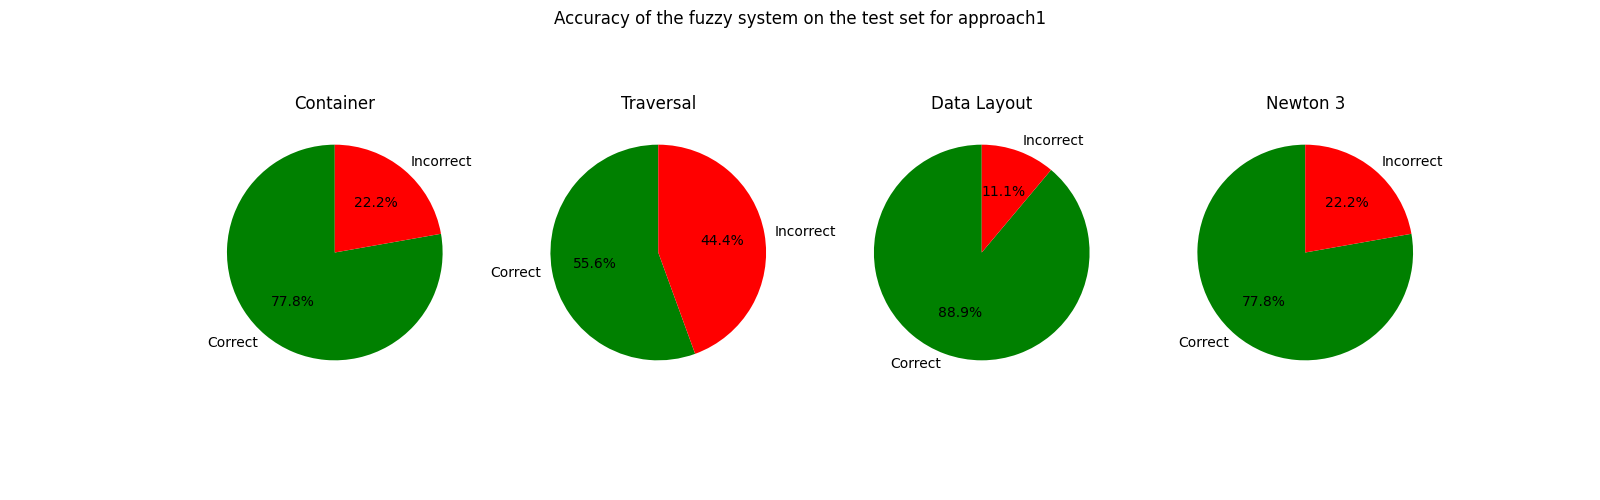

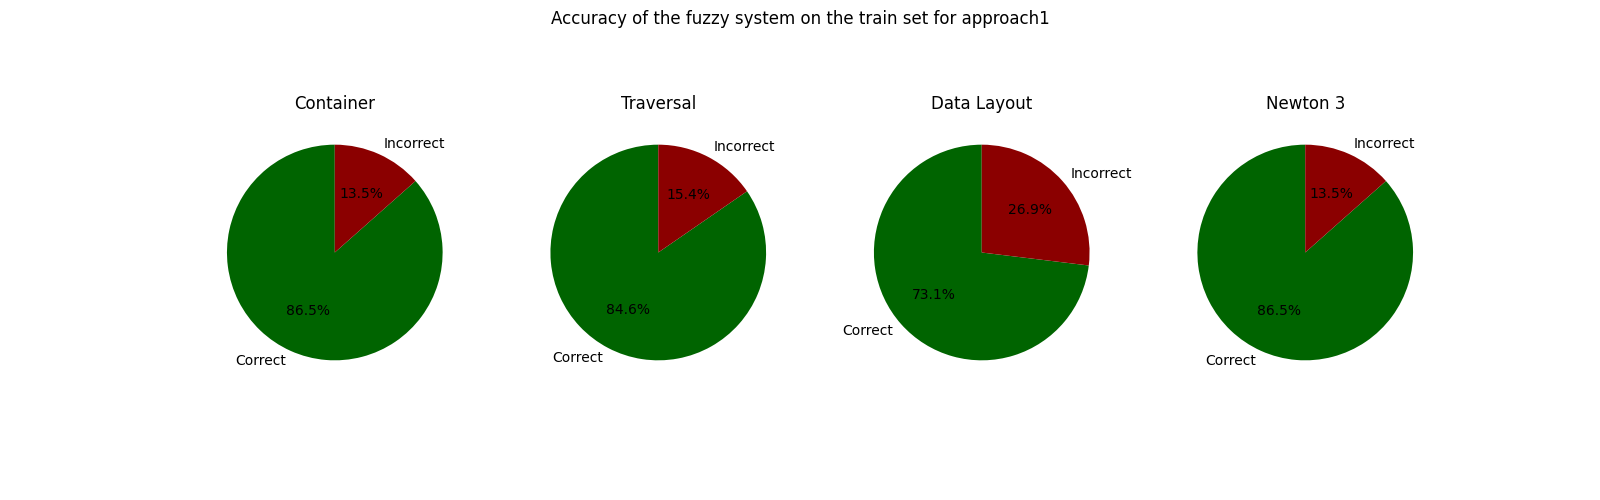

Number of rules:  40
Number of input variables:  5
Number of output variables:  4

approach2:

Container:
	Test set:
		VerletListsCells        :  50.00%	(2/4)
		VerletClusterLists      : 100.00%	(5/5)
		Total                   :  77.78%	(7/9)

	Train set:
		VerletClusterLists      : 100.00%	(18/18)
		LinkedCells             :   0.00%	(0/5)
		VerletListsCells        :  93.10%	(27/29)
		Total                   :  86.54%	(45/52)

Traversal:
	Test set:
		vlc_sliced_c02          : 100.00%	(1/1)
		vlc_c01                 :   0.00%	(0/1)
		vcl_cluster_iteration   : 100.00%	(2/2)
		vcl_c06                 :  33.33%	(1/3)
		vlc_c18                 :  50.00%	(1/2)
		Total                   :  55.56%	(5/9)

	Train set:
		vcl_c06                 : 100.00%	(6/6)
		vcl_cluster_iteration   : 100.00%	(11/11)
		lc_sliced_c02           : 100.00%	(1/1)
		vlc_c01                 :  50.00%	(1/2)
		vcl_c01_balanced        :   0.00%	(0/1)
		vlc_c18                 : 100.00%	(23/23)
		vlc_sliced_c02          

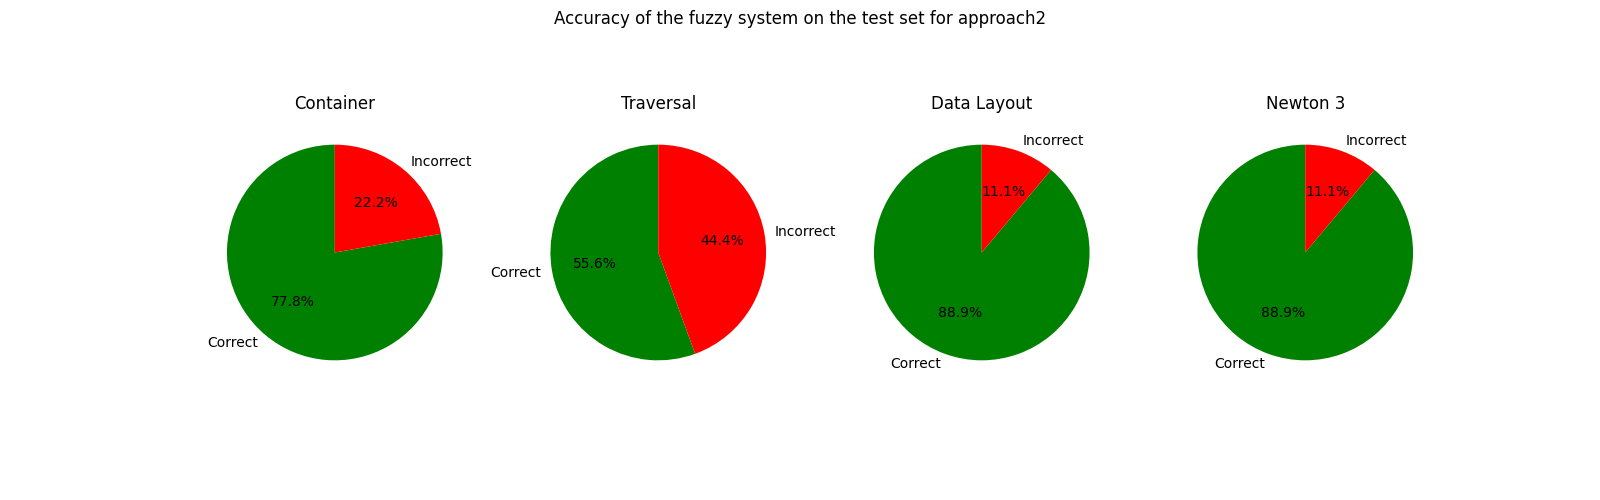

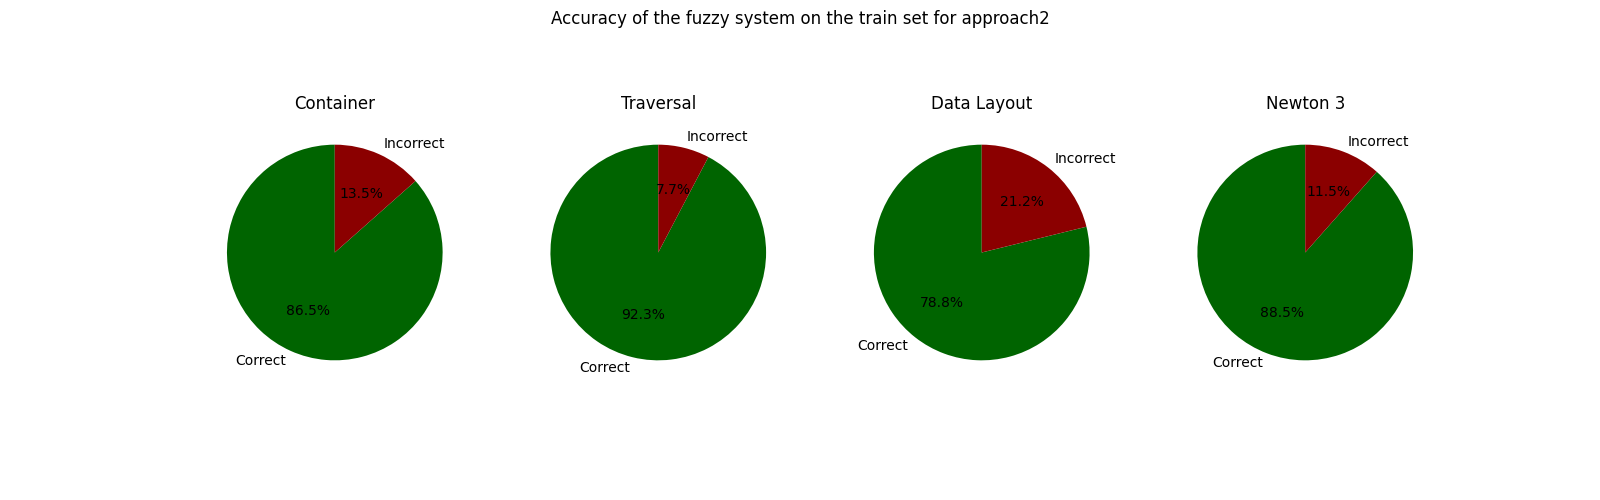

In [19]:
for folder in FOLDERS:

    with open(folder+'/fuzzy-inputs.txt') as f:
        inputVariableString = f.read()

    with open(folder+'/fuzzy-outputs.txt') as f:
        outputVariableString = f.read()

    with open(folder+'/fuzzy-rules.txt') as f:
        rulesString = f.read()

    fiss, algo_ranking = createFuzzySystem(
        inputVariableString, outputVariableString, rulesString)

    print(f"\n{folder}:")

    plot_accuracy(folder, fiss, algo_ranking)

# Findings

- MoM works way better than the other methods.
- This is probably since the output variable is categorical and therefore interpolating between them is not a good idea.
  - Also the placement on the x-axis is somehow arbitrary. This also makes interpolation meaningless
- Traversal is very hard to predict. Maybe because there are so many possible values.

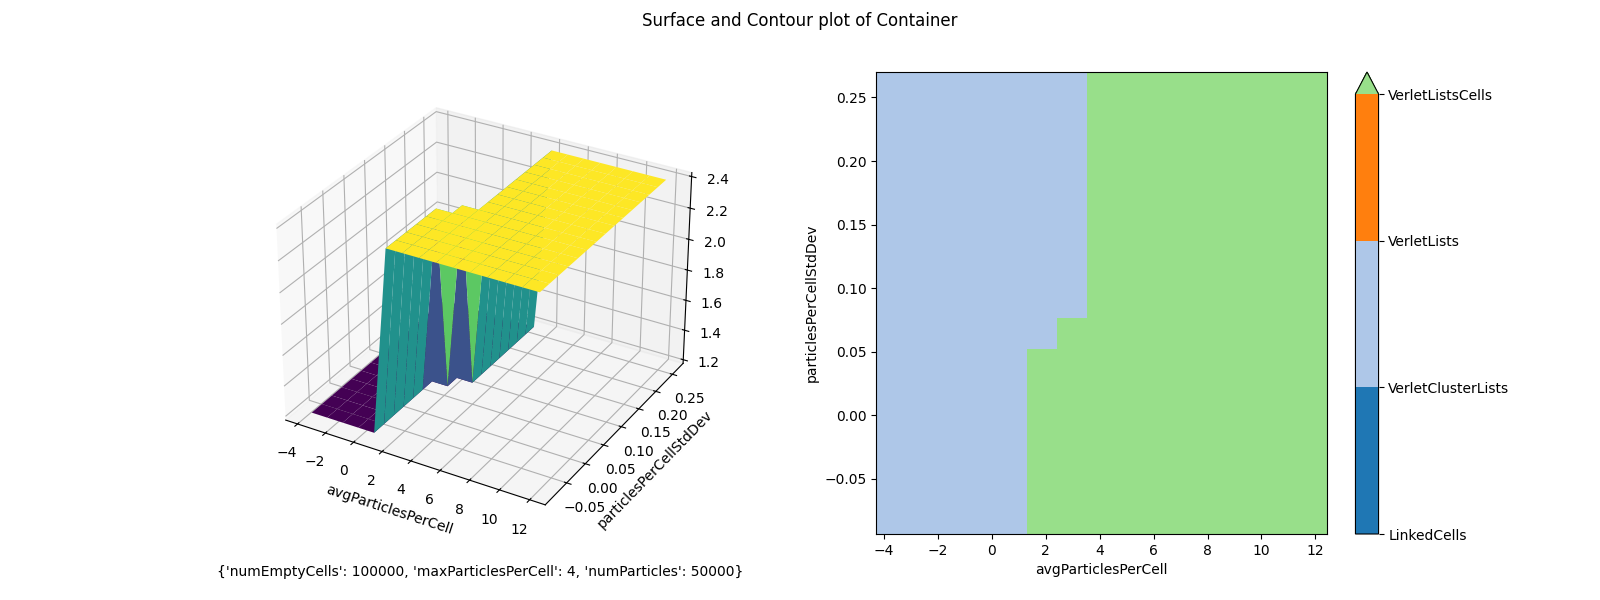

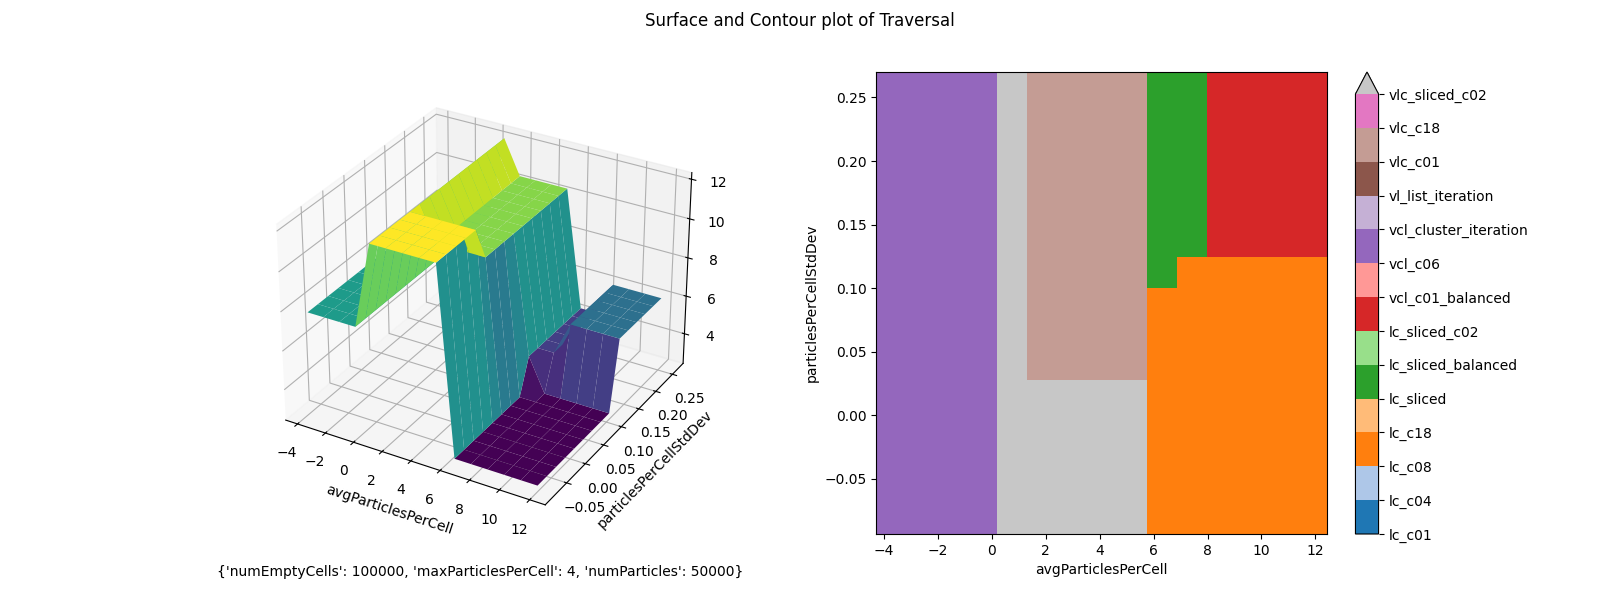

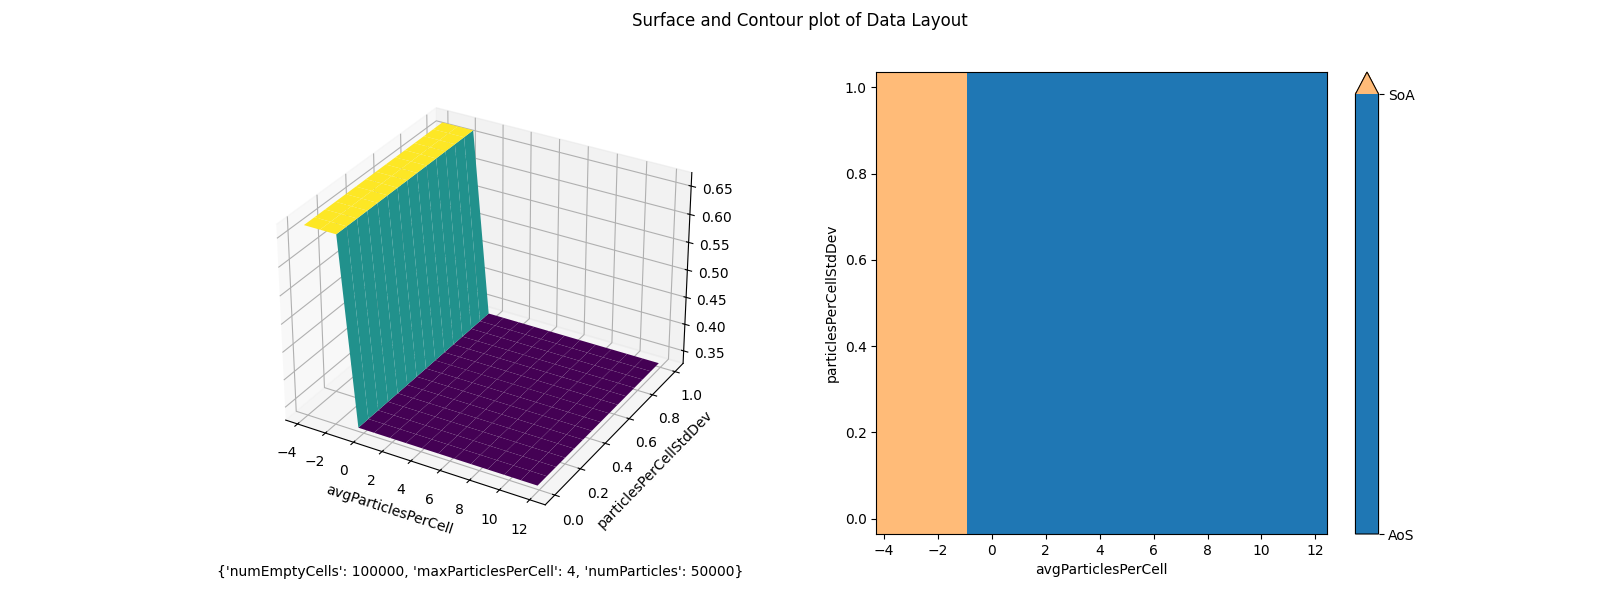

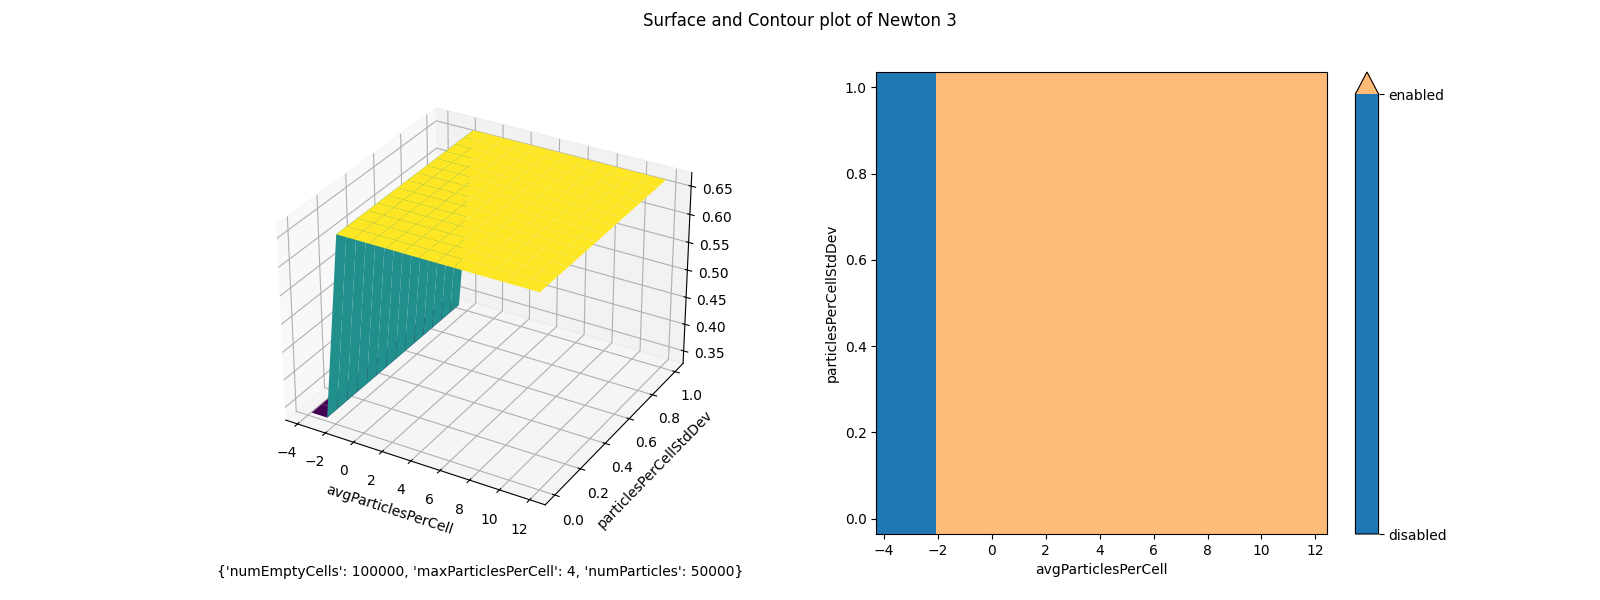

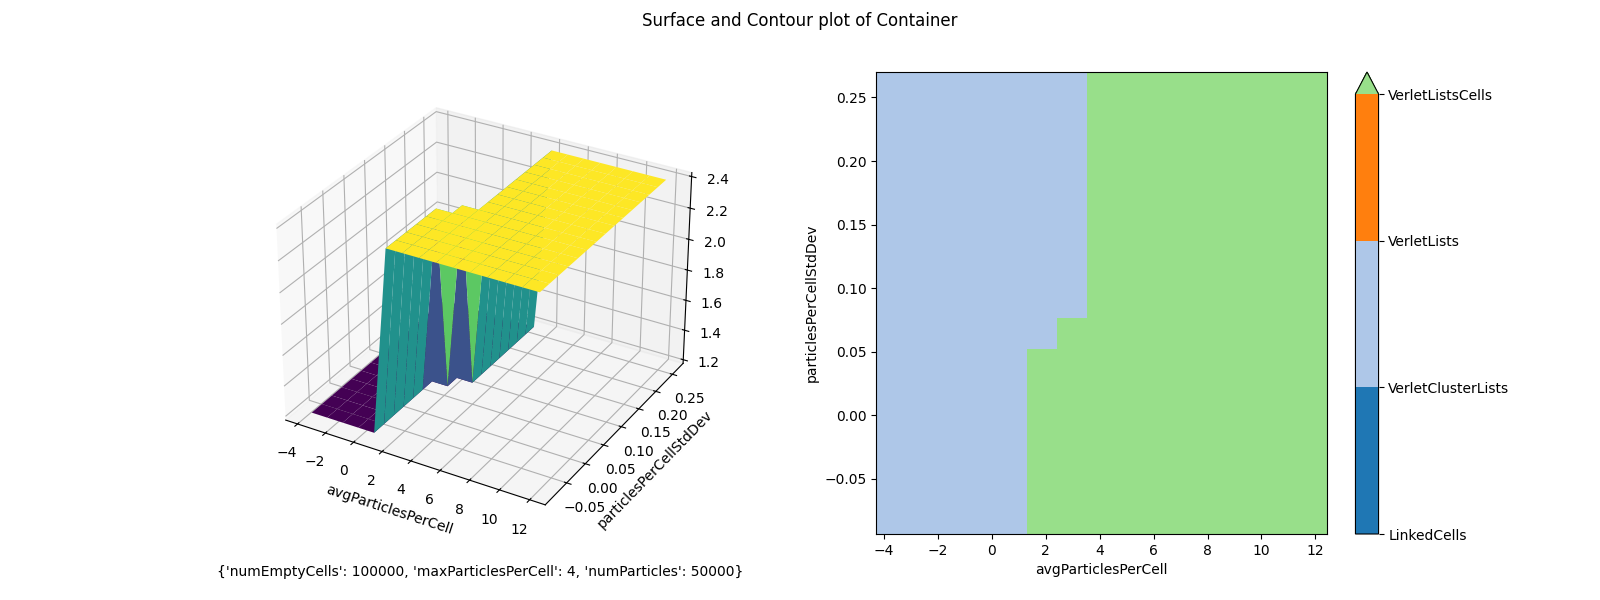

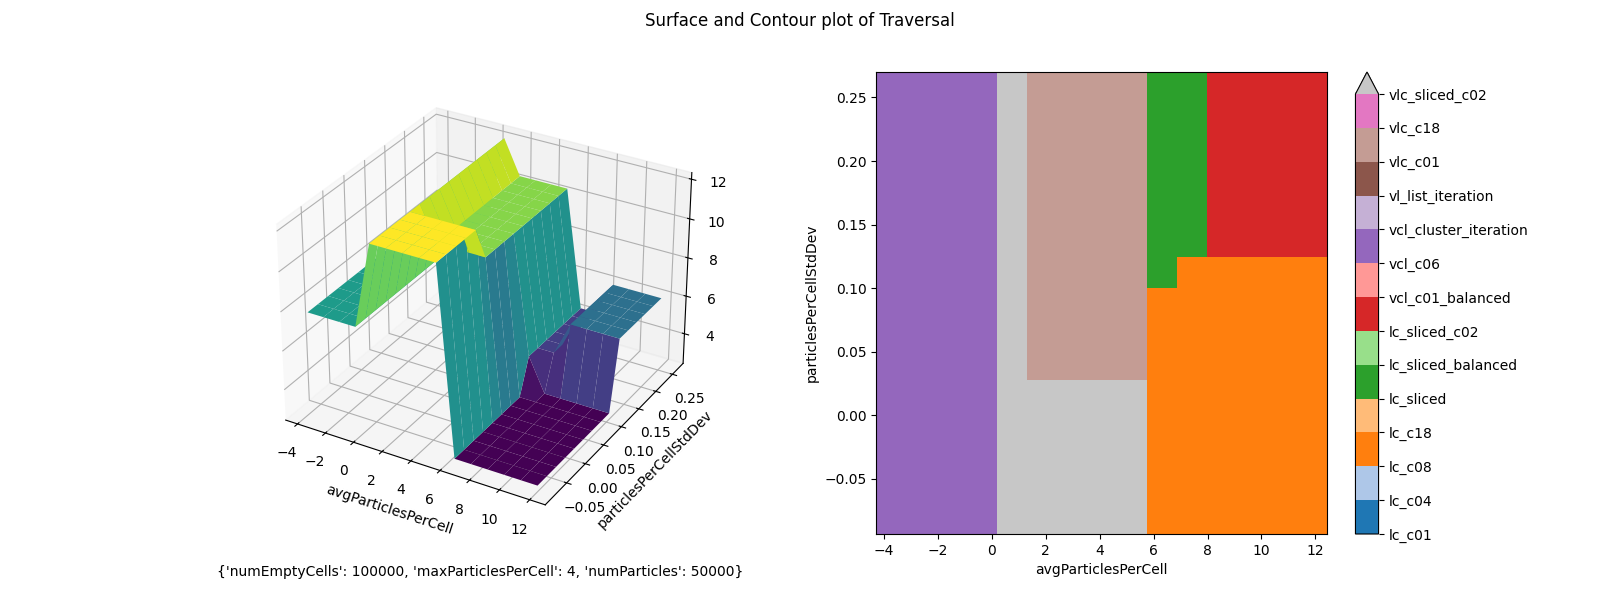

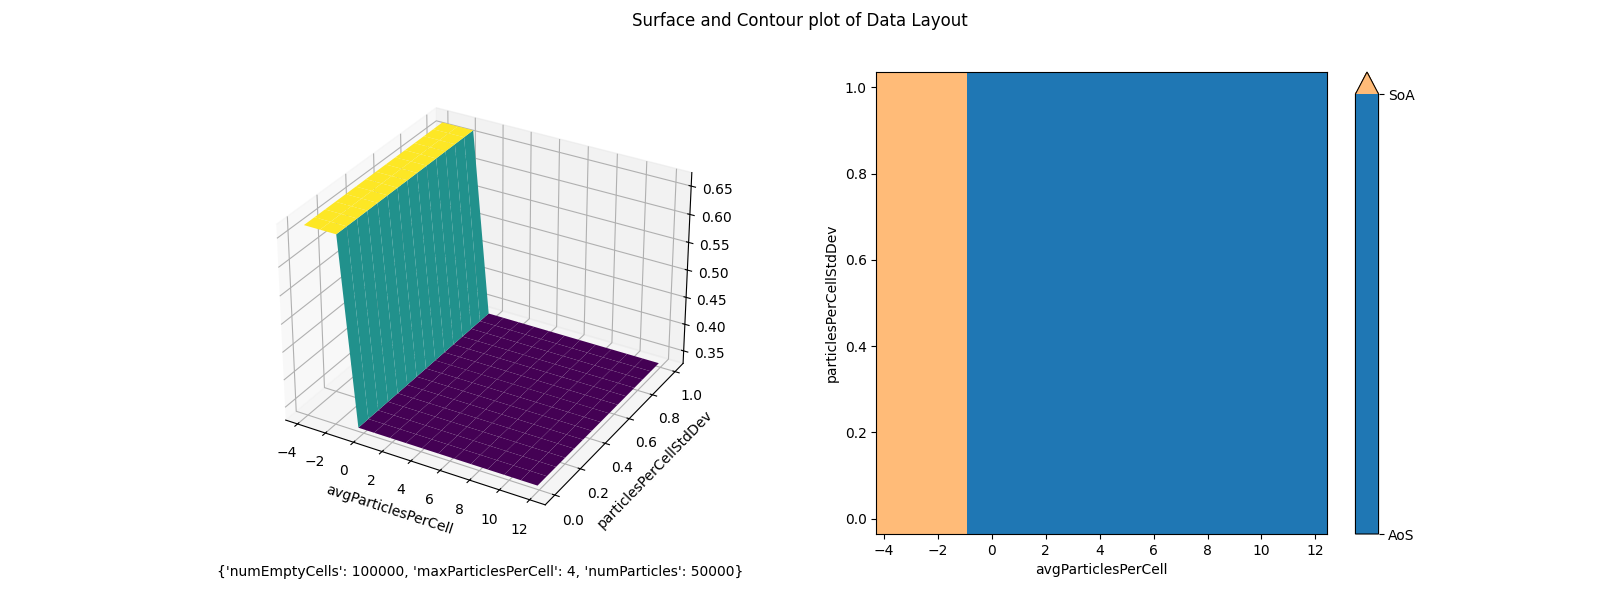

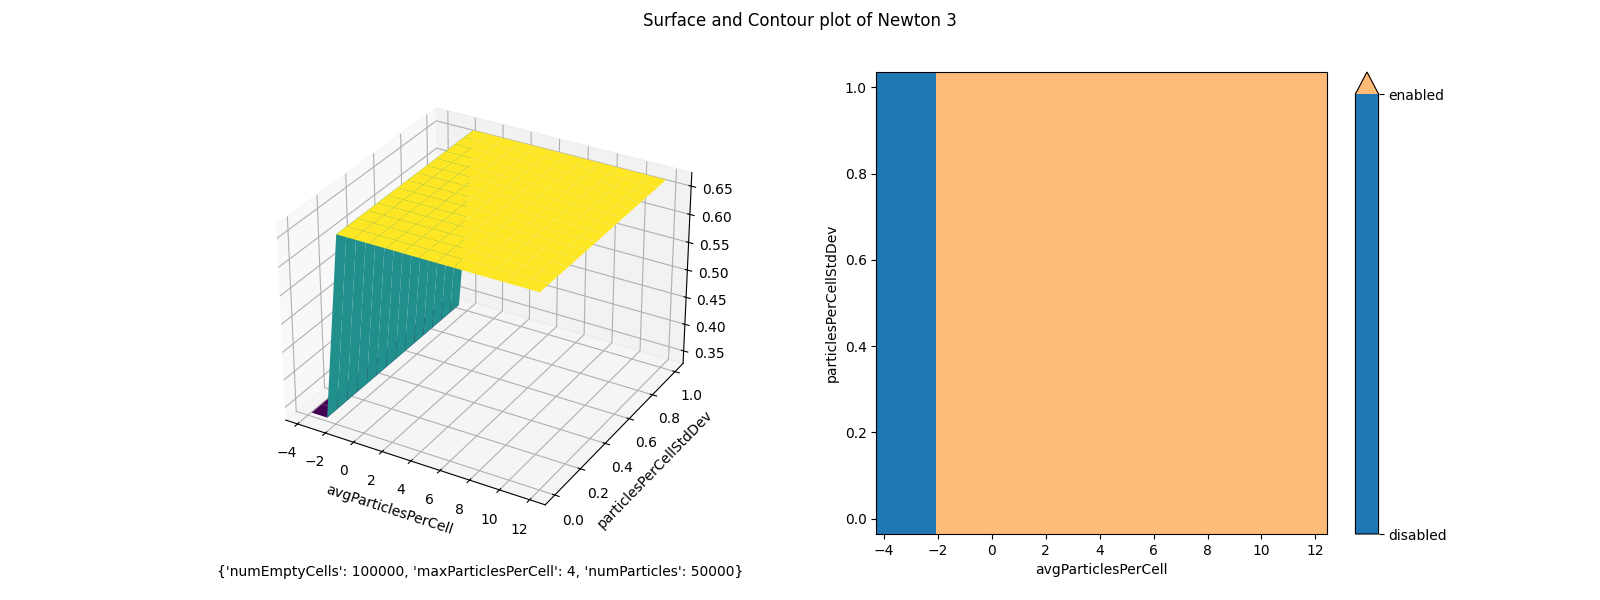

In [20]:
for fis in fiss.values():
    dim = fis.consequent_name
    label_map = {}
    for algo, value in algo_ranking[dim].items():
        label_map[value] = algo

    plot = plot3D_surface(fis.getInputCrispSets(), lambda data: algo_ranking[dim][fis.predictClosest(
        data, algo_ranking[dim])[1]], {
        "y": "particlesPerCellStdDev", "x": "avgParticlesPerCell", "z": dim}, labelMap=label_map, mesh=15, fixed_values={"numEmptyCells": 100000, "maxParticlesPerCell": 4, "numParticles": 50000})
    plot.show()